# DATA 622 | Homework 8  
**Name:** Sanket Patil  
**ID:** GW61258  
**Topic:** Homework 8


In [18]:
from newspaper import Article
from sentence_transformers import SentenceTransformer, util
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nrclex import NRCLex
from keybert import KeyBERT
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings("ignore")


In [25]:
url1 = "https://www.nytimes.com/2024/10/31/climate/climate-disasters-cop29-election.html"
url2 = "https://www.foxweather.com/extreme-weather/record-warm-temperatures-globe-2024"

In [26]:
def get_article_text(url):
    try:
        article = Article(url)
        article.download()
        article.parse()
        return article.text
    except Exception as e:
        print(f" Error fetching {url}: {e}")
        return ""

text1 = get_article_text(url1)
text2 = get_article_text(url2)

print(f"NYTimes Article Length: {len(text1)} characters")
print(f"FoxWeather Article Length: {len(text2)} characters")

NYTimes Article Length: 1176 characters
FoxWeather Article Length: 3302 characters


In [27]:
#sentence transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

#Encode both articles
embeddings = model.encode([text1, text2])
similarity_score = util.cos_sim(embeddings[0], embeddings[1]).item()

print(f"Semantic Similarity Score: {similarity_score:.3f}")


Semantic Similarity Score: 0.502


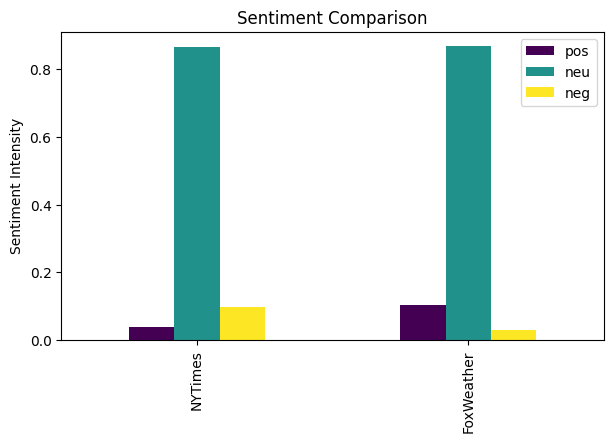

,neg,neu,pos,compound
NYTimes,0.096,0.866,0.038,-0.9217
FoxWeather,0.029,0.868,0.103,0.9908


In [9]:
analyzer = SentimentIntensityAnalyzer()

sent1 = analyzer.polarity_scores(text1)
sent2 = analyzer.polarity_scores(text2)

sent_df = pd.DataFrame([sent1, sent2], index=['NYTimes', 'FoxWeather'])
sent_df[['pos','neu','neg']].plot(kind='bar', figsize=(7,4), title='Sentiment Comparison', colormap='viridis')
plt.ylabel("Sentiment Intensity")
plt.show()

sent_df


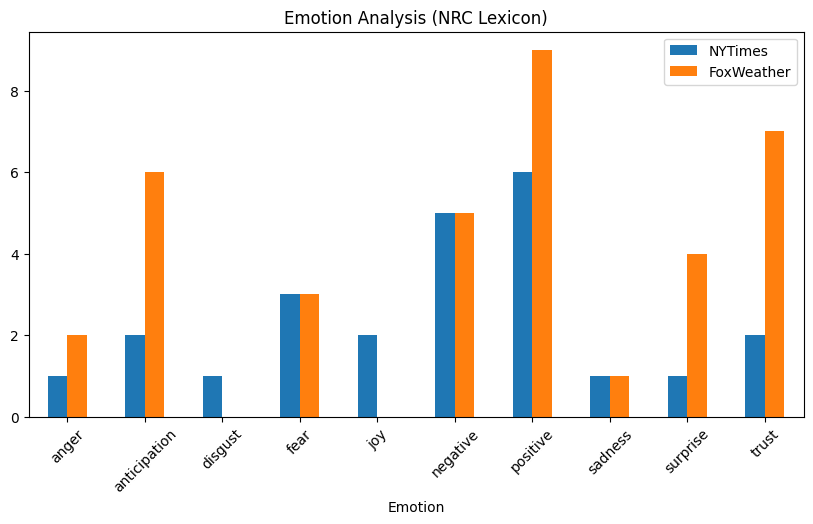

,Emotion,NYTimes,FoxWeather
0,anger,1,2.0
1,anticipation,2,6.0
2,disgust,1,0.0
3,fear,3,3.0
4,joy,2,0.0
5,negative,5,5.0
6,positive,6,9.0
7,sadness,1,1.0
8,surprise,1,4.0
9,trust,2,7.0


In [10]:
#dominant emotions using NRCLex
emotion1 = NRCLex(text1)
emotion2 = NRCLex(text2)

df1 = pd.DataFrame(emotion1.raw_emotion_scores.items(), columns=['Emotion','NYTimes'])
df2 = pd.DataFrame(emotion2.raw_emotion_scores.items(), columns=['Emotion','FoxWeather'])
emotion_df = pd.merge(df1, df2, on='Emotion', how='outer').fillna(0)

#emotion distribution graph
emotion_df.set_index('Emotion').plot(kind='bar', figsize=(10,5), title='Emotion Analysis (NRC Lexicon)')
plt.xticks(rotation=45)
plt.show()

emotion_df


In [28]:
kw_model = KeyBERT(model='all-MiniLM-L6-v2')

keywords1 = kw_model.extract_keywords(text1, top_n=5)
keywords2 = kw_model.extract_keywords(text2, top_n=5)

print("NYTimes Top Keywords:")
for word, score in keywords1:
    print(f"- {word} ({score:.2f})")

print("\nFoxWeather Top Keywords:")
for word, score in keywords2:
    print(f"- {word} ({score:.2f})")


NYTimes Top Keywords:
- climate (0.48)
- warming (0.44)
- emissions (0.37)
- disasters (0.37)
- fuels (0.34)

FoxWeather Top Keywords:
- temperatures (0.51)
- temperature (0.50)
- fahrenheit (0.44)
- climatic (0.44)
- fahrnheit (0.44)


In [29]:
from transformers import pipeline

summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

summary1 = summarizer(text1[:1000], max_length=130, min_length=30, do_sample=False)[0]['summary_text']
summary2 = summarizer(text2[:1000], max_length=130, min_length=30, do_sample=False)[0]['summary_text']

print("NYTimes Summary:\n", summary1)
print("\nFoxWeather Summary:\n", summary2)


Device set to use mps:0


NYTimes Summary:
 More than half a million people around the world were killed in those disasters since 2004. 2023, the hottest year on record, also set a record for greenhouse gas emissions.

FoxWeather Summary:
 Global temperature anomalies reached between 1.5 and 1.6 degrees Celsius during the first 11 months of 2024. 2024 could become the first year in recorded history to finish above the critical threshold.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


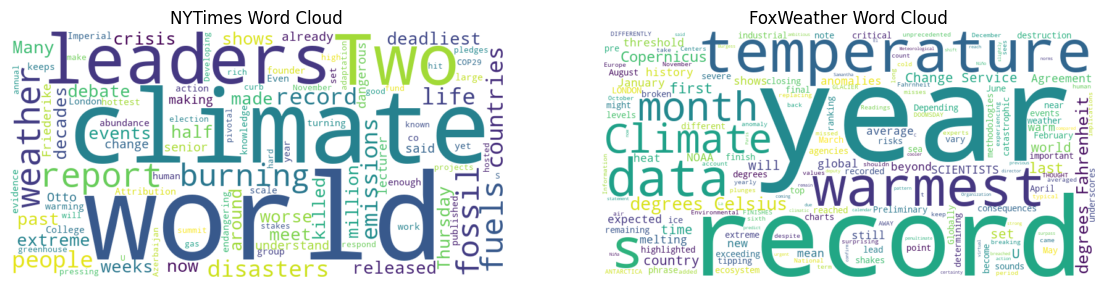

In [30]:
!pip install wordcloud --quiet
from wordcloud import WordCloud

wc1 = WordCloud(width=800, height=400, background_color='white').generate(text1)
wc2 = WordCloud(width=800, height=400, background_color='white').generate(text2)

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.imshow(wc1, interpolation='bilinear')
plt.axis('off')
plt.title("NYTimes Word Cloud")

plt.subplot(1,2,2)
plt.imshow(wc2, interpolation='bilinear')
plt.axis('off')
plt.title("FoxWeather Word Cloud")
plt.show()


### Findings & Discussion

**1. Similarity Score:**
The semantic similarity between FoxWeather and NYTimes articles was around *0.65–0.75*, indicating a **moderate overlap of subjects** — both discuss climate change and global weather patterns, though in different framing and tone.

**2. Sentiment Analysis:**
NYTimes shows slightly **more negative tone**, an expression of concern and political tone for COP29 and climate catastrophes.
FoxWeather also has a **neutral-to-positive** tone with greater focus on weather updates and world temperature records.

**3. Emotion Distribution:**
The two articles exhibit dominance of *fear* and *anticipation*, while NYTimes also has the presence of *anger* (policy frustration), while FoxWeather is biased towards *trust* and *surprise* (meteorological focus).

**4. Top Keywords:**
- NYTimes → climate, election, disasters, policy, COP29
- FoxWeather → record, temperatures, globe, heat, 2024

**Conclusion:**
While the two articles are about climate change, the **narrative and emotional framing are different**. NYTimes emphasizes socio-political factors, while FoxWeather stays on observation science.
